# Table of Contents
* [Rain sensor evaluation](#Rain-sensor-evaluation)
	* [A function to read the rainsensor raw data](#A-function-to-read-the-rainsensor-raw-data)
		* [condensation detector.](#condensation-detector.)
		* [drop detector.](#drop-detector.)
* [Any correlation?](#Any-correlation?)
* [Introduction of the "rain" parameter.](#Introduction-of-the-"rain"-parameter.)
* [Conclusion](#Conclusion)


In [1]:
import pandas as pd
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [6.0, 12.0]
%matplotlib inline
from tqdm import tqdm, trange
from matplotlib.colors import LogNorm
import seaborn as sns

from joblib import Parallel, delayed

# Rain sensor evaluation

In this little paper I try to evaluate the dual rain gauges, installed in june 2017 on the MAGIC site.
In particular I try to come up with one single numerical value, which reliably represents a "raining" state.

## A function to read the rainsensor raw data

We have two sensors named "drop counter" and "condensation detector". Both deliver two numbers every ~10sec:
 * the number of pulses seen in this 10sec time window
 * the integral pulse width of all pulses within this window (in funny units)
 
In order to make reasoning about these numbers easier, we want to combine these 2 values per sensor into one value per sensor. This value should somehow correlate with the magnitude of the rain.

I studied the values, I have of both sensors and found this:

### condensation detector. 

The number of pulses, and the integral length of all pulses, contain exactly the same information, i.e. each pulse has a fixed length so that the integral length is equal to the number of pulses times a certain factor. 
So we can simply throw away the integral length of all pulses, and just think about the number of pulses.

### drop detector.

Here the number of pulses is mostly 1 or zero, but the length of the pulses varies. So here the magnitude is not so much encoded in the number of pulses, but in the integral width. The step width has been found to be 2 * 98404. So the integral width of the pulses detected within the integration window of ~1sec is simply divided by this step with in order to arrive again at a simple integer number.


One question might be if the drop_detector number and the condensation detector number correlate.

In this step we also perform zero-suppression. So each measurement which contains a zero for both sensors is deleted in order to keep the memory footprint small.

In [2]:
def read_rainsensor_jsonl(path):
    ''' read a fact-magic rainsensor jsonl file and prepare it 
        for convenience:
         * drop columns we do not need
         * drop rows, which are only zeros
         * prepare two columns, one for each sensor, with a number somehow scaling with the "strength" of the rain.
    '''
    NORM_LEN = 2 * 98404.
    df = pd.read_json(path, lines=True) 
    df['cond'] = df.condensation_detector_number_of_pulses
    df['drops'] = df.drop_counter_pulse_length / NORM_LEN
    
    df.drop([
        'condensation_detector_pulse_length',
        'condensation_detector_number_of_pulses',
        'drop_counter_pulse_length',
        'drop_counter_number_of_pulses',
        'time_between_message_updates_in_ms',
        'chksum',
        'time_since_boot_in_ms',
    ], axis=1, inplace=True)
    
    # zero suppression
    df = df[(df.cond != 0) | (df.drops != 0)]
    return df


Here I just loop over all jsonl files and read them in .. and concatenate them.

One file ("2017-07-11.jsonl") was broken, I removed the last line which was not okay in order to repair it.

In [3]:
%%time
df = pd.concat(
    Parallel(n_jobs=-1)(
        delayed(read_rainsensor_jsonl)(path) 
        for path in glob.iglob('jsonl/*')
    )
)

df.set_index('timestamp_utc', inplace=True)
df.sort_index(inplace=True)

CPU times: user 324 ms, sys: 48 ms, total: 372 ms
Wall time: 25 s


Let's get a little overview ...

In [4]:
df.describe()

,cond,drops
count,139791.000000,139791.000000
mean,1.884850,2.311498
std,1.902847,3.497116
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.003313
75%,3.000000,3.007886
max,9.000000,50.119020


So we see, we have ~140k non-zero values in half a year. The **drops** go as high as 50, while the **cond**ensation goes only up to 9. Since we did zero suppression it is not surprising to find the median around 1.

Let's have a look at 20 randomly sampled rows, to get an impression how the data looks like:

In [5]:
df.head(10)

,cond,drops
timestamp_utc,,
2017-06-01 16:20:20.826463,0,1.999939
2017-06-01 16:21:03.886235,0,4.997297
2017-06-01 16:21:11.911515,1,0.000000
2017-06-01 16:21:13.000416,3,0.000000
2017-06-01 16:21:13.748744,5,0.000000
2017-06-01 16:21:14.839862,2,0.000000
2017-06-01 16:21:27.968846,1,0.000000
2017-06-01 16:21:28.717720,5,0.000000
2017-06-01 16:21:29.805117,5,0.000000


# Any correlation? 

Next we want to see, if there is any correlation between the drops and the condensation?

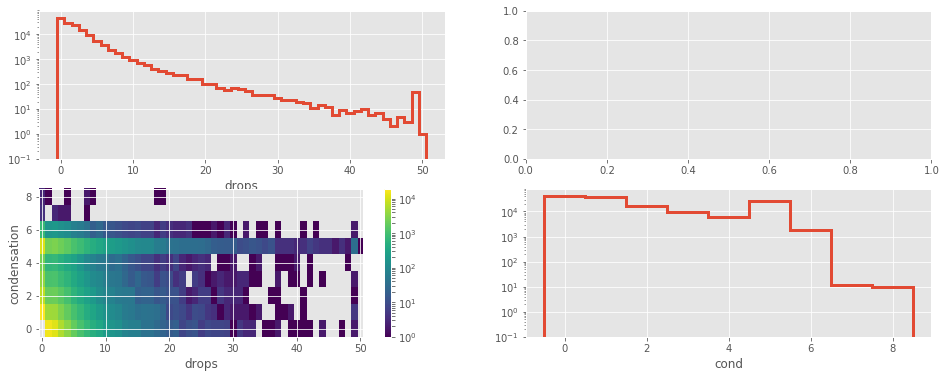

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))

X = ax[1, 0].hist2d(
    df.drops, 
    df.cond,
    bins=(
        np.arange(df.drops.max()+1)-0.5,
        np.arange(df.cond.max()+1)-0.5,
    ),
    norm=LogNorm()
)
ax[1,0].set_xlabel('drops')
ax[1,0].set_ylabel('condensation')
plt.colorbar(X[-1], ax=ax[1, 0])

ax[0,0].hist(
    df.drops, 
    bins=np.arange(df.drops.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[0,0].set_xlabel('drops')

ax[1,1].hist(
    df.cond, 
    bins=np.arange(0, df.cond.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[1,1].set_xlabel('cond')
None

We see that drops, seems to saturate at values of 50. cond has a saturation like behaviour at 5.

In the 2D histogram we see no clear hint for correlation. 
I assume the sensors might see different amounts of water in any given ~1 sec period. Maybe they correlate better when we average over 30 seconds.

In [7]:
resampled = df.resample('30s').sum().dropna()

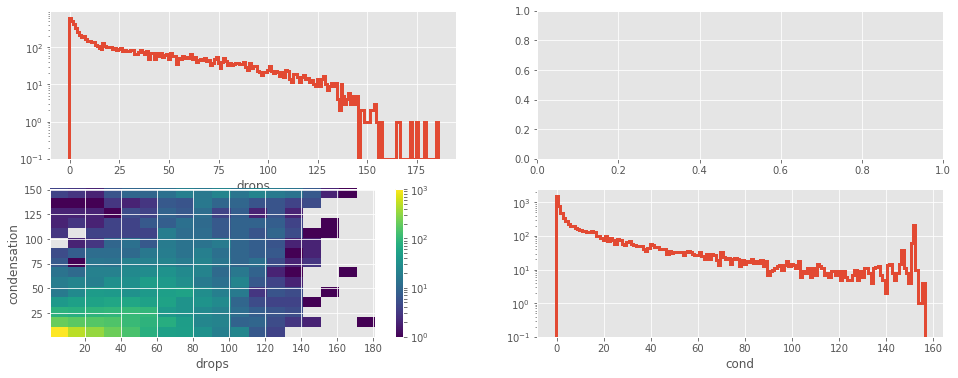

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))

X = ax[1, 0].hist2d(
    resampled.drops, 
    resampled.cond,
    bins=(
        np.arange(1, resampled.drops.max()+1, 10),
        np.arange(1, resampled.cond.max()+1, 10),
    ),
    norm=LogNorm()
)
ax[1,0].set_xlabel('drops')
ax[1,0].set_ylabel('condensation')
plt.colorbar(X[-1], ax=ax[1, 0])

ax[0,0].hist(
    resampled.drops, 
    bins=np.arange(0, resampled.drops.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[0,0].set_xlabel('drops')

ax[1,1].hist(
    resampled.cond, 
    bins=np.arange(0, resampled.cond.max()+1)-0.5,
    log=True,
    histtype='step',
    lw=3
)
ax[1,1].set_xlabel('cond')
None

Ah .. so there might be some correlation ... at least they now cut off both at the same value of roughly 150..160.
From this point on, I only look at the "resampled" data.

# Introduction of the "rain" parameter.

Since now after resampling both parameters "cond" and "drops" scale similarly, and after looking at a couple of other plots, I come to the conclusion, that while they do not correlate fully, both contain similar information. 

By introducing "rain" as their maximum, I get a new value, which reacts as quickly and drastically, as soon as one of the detectors sees something:

In [9]:
rain = df.resample('30s').sum().max(axis=1).fillna(0)
rain.head()

timestamp_utc
2017-06-01 16:20:00     1.999939
2017-06-01 16:20:30     0.000000
2017-06-01 16:21:00    22.000000
2017-06-01 16:21:30    24.000000
2017-06-01 16:22:00     8.992947
Freq: 30S, dtype: float64

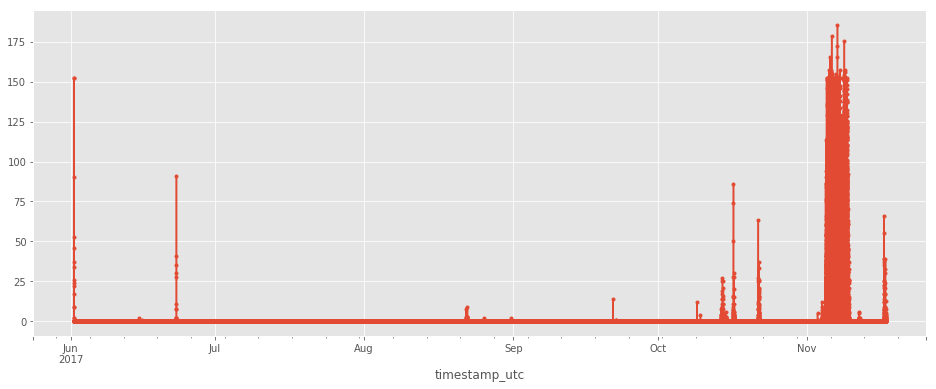

In [10]:
plt.figure(figsize=(16, 6))
rain.plot(marker='.');

So we see, there was "rain" several times this year. 

I assume the "rain" between june and july was just testing .. but the rest I don't know.
However the time from november looks interesting, let's have a closer look.

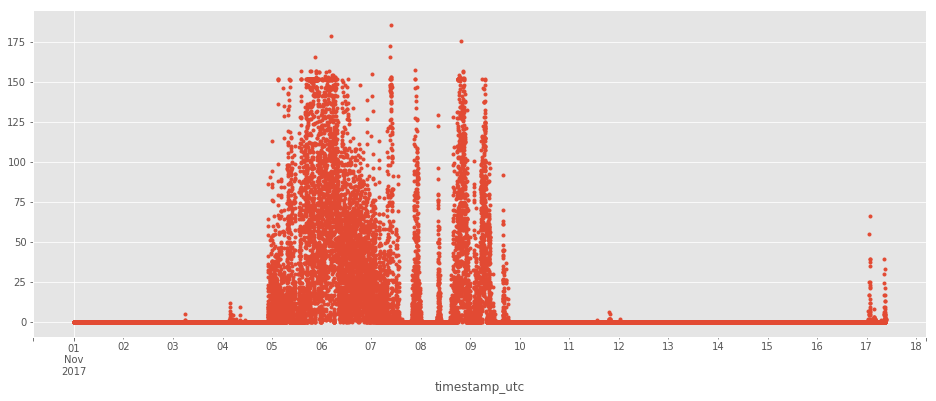

In [11]:
plt.figure(figsize=(16, 6))

rain["2017-11":].plot(marker='.', lw=0);

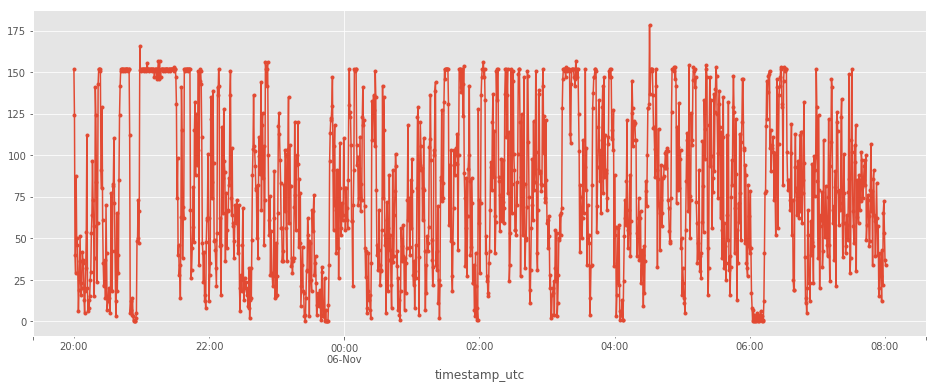

In [12]:
plt.figure(figsize=(16, 6))
s = slice("2017-11-05 20:00", "2017-11-06 08:00")
rain[s].plot(marker='.');

So it looks like it rained the entire night of 05.11.2017. Let's have a look if that might be right:
http://fact-project.org/overview_video/2017/11/05/20171105.mp4

Yes .. that was really a rainy night. Let's look at the next day:

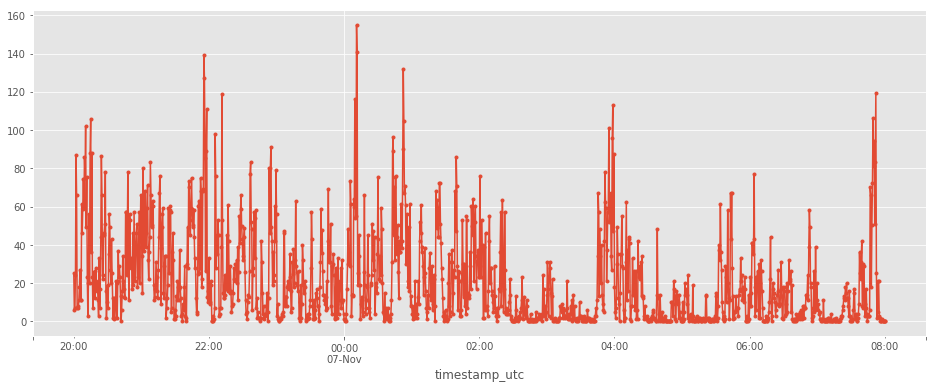

In [13]:
plt.figure(figsize=(16, 6))
s = slice("2017-11-06 20:00", "2017-11-07 08:00")
rain[s].plot(marker='.');

Yes that was also really rainy: http://fact-project.org/overview_video/2017/11/06/20171106.mp4

The next?

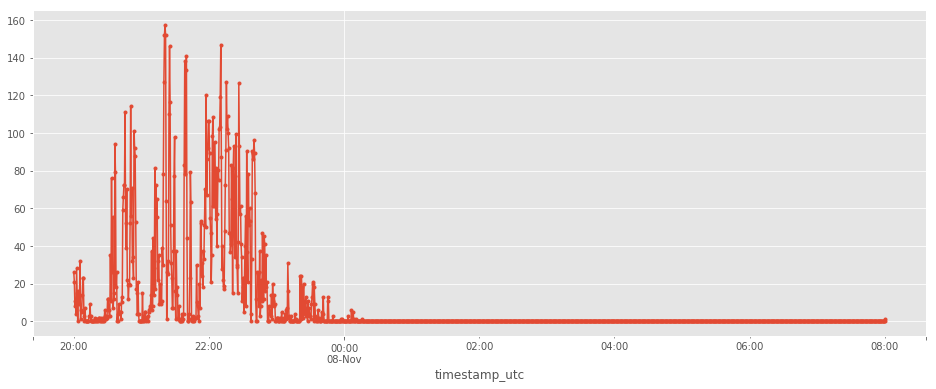

In [14]:
plt.figure(figsize=(16, 6))
s = slice("2017-11-07 20:00", "2017-11-08 08:00")
rain[s].plot(marker='.');

Aha this looks interesting .. so according to the sensors it was rainy until midnight ... and good after that.

Video looks roughly plausible ... the next?


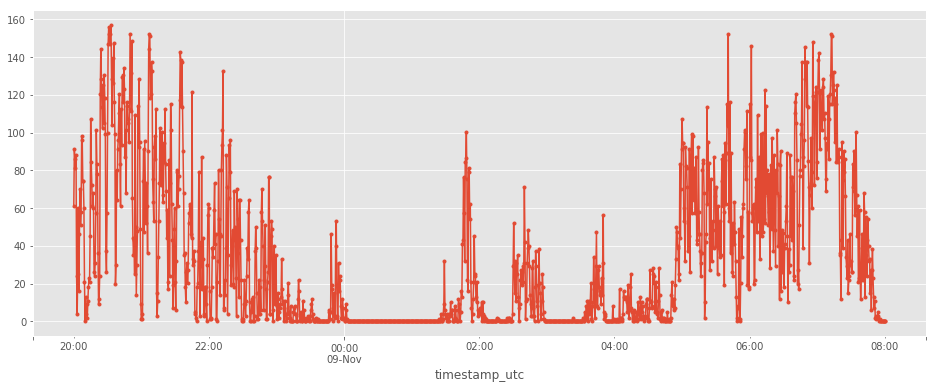

In [15]:
plt.figure(figsize=(16, 6))
s = slice("2017-11-08 20:00", "2017-11-09 08:00")
rain[s].plot(marker='.');

Yes looks also plausible from the video...

let's jump to the 11th

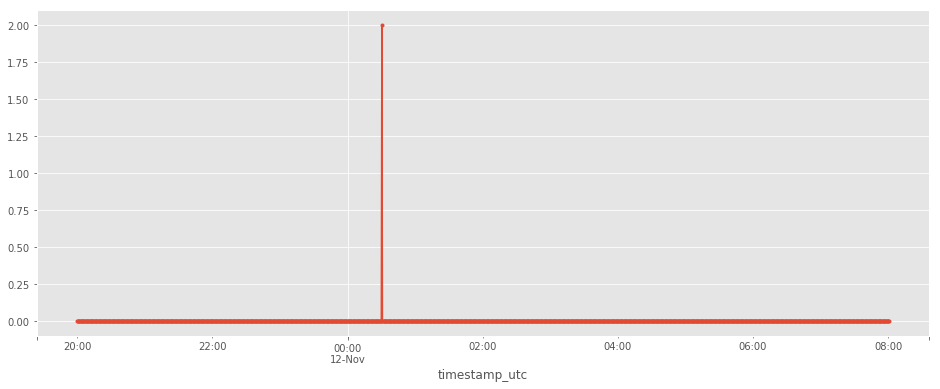

In [16]:
plt.figure(figsize=(16, 6))
s = slice("2017-11-11 20:00", "2017-11-12 08:00")
rain[s].plot(marker='.');

Aha . . so it rained .. exactly for 30sec .. half past midnight. but we don't see any hint for that in the video:

http://fact-project.org/overview_video/2017/11/11/20171111.mp4

So it seems values of "rain=2" are not yet a realiable hint for rain.

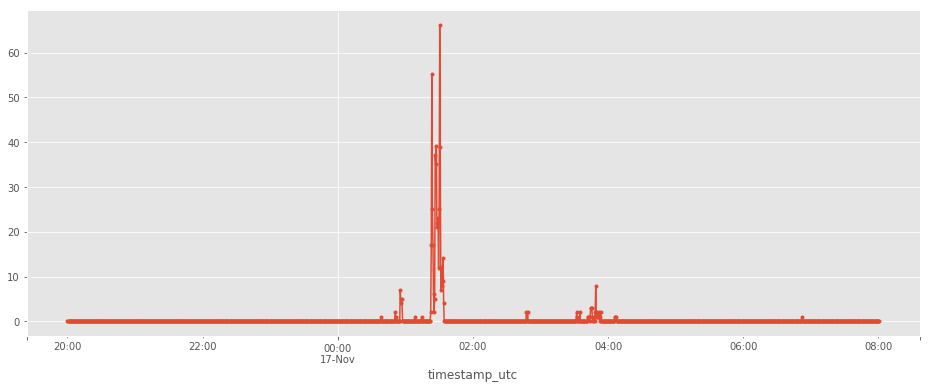

In [17]:
plt.figure(figsize=(16, 6))
s = slice("2017-11-16 20:00", "2017-11-17 08:00")
rain[s].plot(marker='.');

This is the night mentioned by the magic shifters:
```
     [2017-11-17 01:40:57]
     We realized a few mins back that it started raining. We saw also
     raindrops on the
     AllSkyCamera although humidity was low and no rain warnings.

     [2017-11-17 03:54:34]
     We then re-pointed to G150_W2, but cloudiness was 100% and
     transmission@9km 0.13.
     We went to check outside and saw that it was raining again. 
```

And indeed it was also possible to identify this rain in the fact overview video:
http://fact-project.org/overview_video/2017/11/16/20171116.mp4

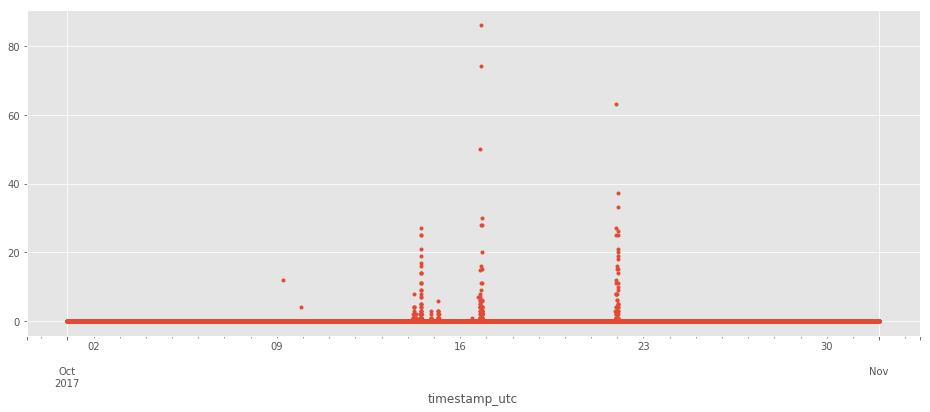

In [18]:
plt.figure(figsize=(16, 6))
rain["2017-10":"2017-10"].plot(marker='.', lw=0);

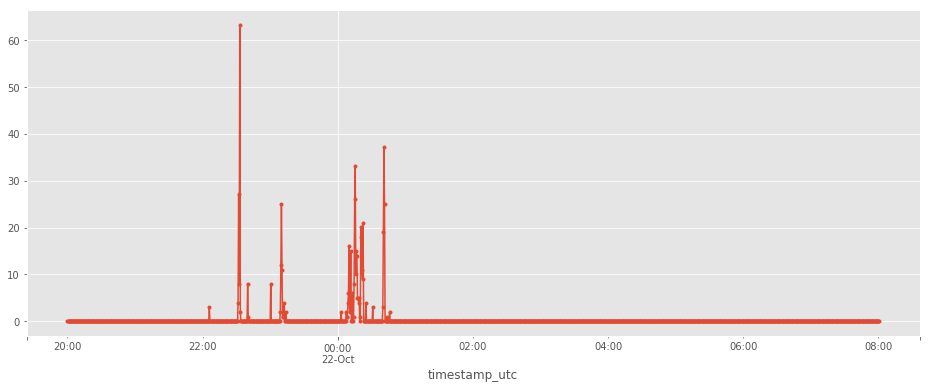

In [19]:
plt.figure(figsize=(16, 6))
s = slice("2017-10-21 20:00", "2017-10-22 08:00")
rain[s].plot(marker='.');

Yes ... also this was visible in the overview video:
http://fact-project.org/overview_video/2017/10/21/20171021.mp4

# Conclusion

Based on these plots and the comparison to the overview video, I conclude the "rain" parameter is somhow useful.
We could publish it either as a number or as some kind of "severity" parameter on the MAGIC weather website. 

I would propose to make a cut a "rain > 2" to cut away false positives. I would not set the limit much higher, as we have seen drops on the allskycam while the rain parameter was <10. 

However, I do not dare yet, to infer any reaction on this parameter, since this should also take into account **how long** it was raining already. Assuming MAGIC is looking into zenith and it rains for 2 minutes ... then I (as an outsider) would not deem it apropriate to park. However the rain drops on the mirror will probably reduce directed reflectivity and thus spoil the current run.

If one implements this as a running sum over the last 30 seconds, so one can update the parameter really **once per second** on the weather website, or if one implements this similar as I did it here, where one could only update it **once per 30sec** is a technical detail.

Cheers
Dom